__Note:__ In the below code, I used 'E' and 'N' as coordinates because the analysis is assumed to be on a plane. 
Usually we cannot directly consider latitude and longitude as x and y coordinates because they are spherical (good to see <https://en.wikipedia.org/wiki/Geographic_coordinate_system>). But given that it is a (relatively) small area covered by the dataset, if you would like to use latitude and longitude, remember to explain in your report that you treat latitude and longitude as locally Euclidean coordinates since the Earch is locally flat.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.image import NonUniformImage
from IPython.display import display, clear_output

In [ ]:
file = '20181101_d1_0800_0830'

if file == '20181029_dX_0800_0830' :
    data = pd.read_hdf('data_' + file + '.h5', 'data')
if file == '20181101_d1_0800_0830' :
    data = pd.read_csv('data_' + file + '.csv')
    data.set_index(['track_id', 'frame_id'], drop=True, inplace=True)

--------------------

Grids can be indexed by `[E_id, N_id]`.

The area in which a grid `[E_id, N_id]` locates is bounded by `[Eedges[E_id - 1], Eedges[E_id])` and `[Nedges[N_id - 1], Nedges[N_id])` .

You may adjust the parameters of `grid_size` and the number in the generation of `time_intervals` to have suitable datasets.

In the outcome of `flows_per_grid` and `speeds_per_grid`, `NaN` means there was no vehicle passing the grid in the time interval.

Feel free to adapt the code to meet your needs. Contact me if you need any help.

In [ ]:
# Calculate the acceleration using the speed and the time (a = delta v / delta t)
data['acceleration'] = (data['speed'] - data['speed'].shift(1)) / (data['time']-data['time'].shift(1))

# Remove the data from the first and the last row of each track_id
for i in range(len(data)):
    if np.array(data.index[i])[0] > np.array(data.index[i-1])[0]:
        data['acceleration'].iloc[i] = np.nan
        data['acceleration'].iloc[i-1] = np.nan

In [ ]:
# Calcultate direction
x = data['E_heading']
y = data['N_heading']

def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

data['direction']  = np.degrees(cart2pol(x,y)[1])

display(data)

lat        lon     speed  lon_acc  lat_acc    time  \
track_id frame_id                                                             
1        960       37.977484  23.737106  3.744083   0.0466  -0.0660   38.40   
         961       37.977484  23.737107  3.744750   0.0383  -0.0711   38.44   
         962       37.977485  23.737109  3.745167   0.0329  -0.0761   38.48   
         963       37.977485  23.737110  3.745444   0.0298  -0.0810   38.52   
         964       37.977486  23.737112  3.745639   0.0247  -0.0860   38.56   
...                      ...        ...       ...      ...      ...     ...   
636      17610     37.978768  23.736271  1.555417   0.1826  -0.1181  704.40   
         17611     37.978768  23.736272  1.562694   0.1810  -0.1207  704.44   
         17612     37.978769  23.736272  1.569944   0.1806  -0.1233  704.48   
         17613     37.978769  23.736273  1.577167   0.1818  -0.1258  704.52   
         17614     37.978769  23.736273  1.584417   0.1805  -0.1279  704.56   

                             E            N  E_heading  N_heading  \
track_id frame_id                                                   
1        960       740406.4532  4206851.876   0.692995   0.353623   
         961       740406.5411  4206851.879   0.692995   0.353623   
         962       740406.7135  4206851.995   0.692995   0.353623   
         963       740406.8014  4206851.997   0.692995   0.353623   
         964       740406.9738  4206852.113   0.692995   0.353623   
...                        ...          ...        ...        ...   
636      17610     740328.9085  4206992.220   0.260277   0.118734   
         17611     740328.9964  4206992.223   0.257013   0.229716   
         17612     740328.9931  4206992.334   0.260277   0.118734   
         17613     740329.0810  4206992.336   0.260277   0.118734   
         17614     740329.0810  4206992.336   0.344860   0.232300   

                   acceleration  direction  
track_id frame_id                           
1        960                NaN  27.034438  
         961           0.016667  27.034439  
         962           0.010417  27.034441  
         963           0.006944  27.034441  
         964           0.004861  27.034443  
...                         ...        ...  
636      17610         0.180556  24.521570  
         17611         0.181944  41.790068  
         17612         0.181250  24.521571  
         17613         0.180556  24.521572  
         17614         0.181250  33.964426  

[1048575 rows x 12 columns]

In [ ]:
grid_size = 15 # unit: meter
Eedges = np.array(range(np.floor(data['E'].values.min()).astype(int), np.ceil(data['E'].values.max()).astype(int) + grid_size, grid_size))
Nedges = np.array(range(np.floor(data['N'].values.min()).astype(int), np.ceil(data['N'].values.max()).astype(int) + grid_size, grid_size))

bins = [Eedges, Nedges]
grid_E_id = np.digitize(data['E'].values, Eedges, right=False) # right=False means Eedges[i-1] <= x < Eedges[i]
grid_N_id = np.digitize(data['N'].values, Nedges, right=False)

data['E_id'] = grid_E_id
data['N_id'] = grid_N_id

In [ ]:
grid_indices = data[['E_id', 'N_id']].drop_duplicates().values
time_intervals = np.array(range(data.index.get_level_values(1).min(), data.index.get_level_values(1).max()+1, 700)) 
# the number 360 is chosen by hand; this generates 59 intervals and each interval is 14.4 seconds; other possible numbers could be factors of 21240
#time_intervals = np.array(range(data.index.get_level_values(1).min(), data.index.get_level_values(1).max()+2, 700)) 
# the number 700 is chosen by hand; this generates 26 intervals and each interval is 28 seconds; other possible numbers could be factors of 18200

speeds_per_grid = np.zeros((grid_indices.shape[0], time_intervals.shape[0] - 1))
density_per_grid = np.zeros((grid_indices.shape[0], time_intervals.shape[0] - 1))
acc_per_grid = np.zeros((grid_indices.shape[0], time_intervals.shape[0] - 1))
direction_per_grid = np.zeros((grid_indices.shape[0], time_intervals.shape[0] - 1))

for i in range(grid_indices.shape[0]):
    
    clear_output(wait=True)
    display('---- i =' + str(i) + ' ---')
    
    grid_index = grid_indices[i]
    data_grid = data[np.all(data[['E_id', 'N_id']]==grid_index, axis=1)]
    densitys = np.zeros(time_intervals.shape[0]-1)
    speeds = np.zeros(time_intervals.shape[0]-1)
    acc = np.zeros(time_intervals.shape[0]-1)
    direction = np.zeros(time_intervals.shape[0]-1)

    for t in range(time_intervals.shape[0]-1):
        if t == time_intervals.shape[0]-2 : # the last interval should include the right bound, which is different from other intervals 
            density = data_grid[np.logical_and(data_grid['time'] >= time_intervals[t] / 25, data_grid['time'] <= time_intervals[t+1] / 25)].index.get_level_values(0).drop_duplicates().shape[0]
            speed = data_grid[np.logical_and(data_grid['time'] >= time_intervals[t] / 25, data_grid['time'] <= time_intervals[t+1] / 25)]['speed'].mean()
            accs = data_grid[np.logical_and(data_grid['time'] >= time_intervals[t] / 25, data_grid['time'] <= time_intervals[t+1] / 25)]['acceleration'].mean()
            directions = data_grid[np.logical_and(data_grid['time'] >= time_intervals[t] / 25, data_grid['time'] <= time_intervals[t+1] / 25)]['direction'].std()
        else:
            density = data_grid[np.logical_and(data_grid['time'] >= time_intervals[t] / 25, data_grid['time'] < time_intervals[t+1] / 25)].index.get_level_values(0).drop_duplicates().shape[0]
            speed = data_grid[np.logical_and(data_grid['time'] >= time_intervals[t] / 25, data_grid['time'] < time_intervals[t+1] / 25)]['speed'].mean()
            accs = data_grid[np.logical_and(data_grid['time'] >= time_intervals[t] / 25, data_grid['time'] < time_intervals[t+1] / 25)]['acceleration'].mean()
            directions = data_grid[np.logical_and(data_grid['time'] >= time_intervals[t] / 25, data_grid['time'] < time_intervals[t+1] / 25)]['direction'].std()
        if np.isnan(speed):
            densitys[t] = 0
            speeds[t] = 30
            acc[t] = 10
            direction[t] = 0
        else:
            densitys[t] = density
            speeds[t] = speed
            acc[t] = accs
            direction[t] = directions
    
    density_per_grid[i] = densitys
    speeds_per_grid[i] = speeds
    acc_per_grid[i] = acc
    direction_per_grid[i] = direction

density_per_grid = pd.DataFrame(density_per_grid)
density_per_grid[['E_id', 'N_id']] = grid_indices
density_per_grid.set_index(['E_id', 'N_id'], drop=True, inplace=True)

speeds_per_grid = pd.DataFrame(speeds_per_grid)
speeds_per_grid[['E_id', 'N_id']] = grid_indices
speeds_per_grid.set_index(['E_id', 'N_id'], drop=True, inplace=True)

acc_per_grid = pd.DataFrame(acc_per_grid)
acc_per_grid[['E_id', 'N_id']] = grid_indices
acc_per_grid.set_index(['E_id', 'N_id'], drop=True, inplace=True)

direction_per_grid = pd.DataFrame(direction_per_grid)
direction_per_grid[['E_id', 'N_id']] = grid_indices
direction_per_grid.set_index(['E_id', 'N_id'], drop=True, inplace=True)

'---- i =171 ---'

In [ ]:
direction_per_grid = direction_per_grid.fillna(0)

speeds_per_grid.to_csv('new_speeds_per_grid_' + file + '.csv')
density_per_grid.to_csv('new_density_per_grid_' + file + '.csv')
acc_per_grid.to_csv('new_acceleration_per_grid_'+ file + '.csv')
direction_per_grid.to_csv('new_direction_per_grid_'+ file + '.csv')

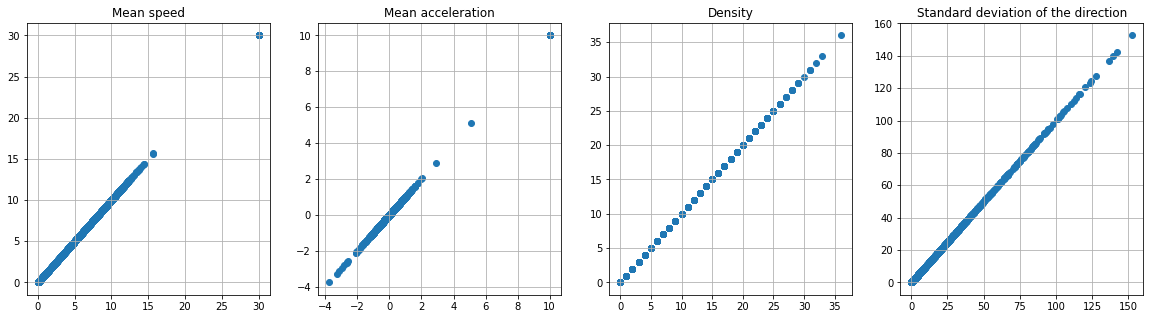

In [ ]:
plt.figure(figsize=(20,5))
plt.subplot(1,4,1)
plt.scatter(speeds_per_grid.iloc[:,2:], speeds_per_grid.iloc[:,2:])
plt.title('Mean speed')
plt.grid()

plt.subplot(1,4,2)
plt.scatter(acc_per_grid.iloc[:,2:], acc_per_grid.iloc[:,2:])
plt.title('Mean acceleration')
plt.grid()

plt.subplot(1,4,3)
plt.scatter(density_per_grid.iloc[:,2:], density_per_grid.iloc[:,2:])
plt.title('Density')
plt.grid()

plt.subplot(1,4,4)
plt.scatter(direction_per_grid.iloc[:,2:], direction_per_grid.iloc[:,2:])
plt.title('Standard deviation of the direction')
plt.grid()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=dc8bb720-d815-4ecd-8bea-56e83d6bf798' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>